<a href="https://colab.research.google.com/github/nina-mizrahi/ML-and-Neural-Networks/blob/main/Convolutional_Neural_Network_for_facial_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hommework 16**

In this assignment you will create a Convolutional Neural Network to do facial recognition. We begin by importing a dataset of face photos. This is a very large dataset, and may take a while to load. Once it is complete we will just look at a subset, consisting of people for whom there are at least 70 photos.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
faces=lfw_people.images
names=lfw_people.target_names
target=lfw_people.target

for name in names:
  print(name)

faces.shape

Ariel Sharon
Colin Powell
Donald Rumsfeld
George W Bush
Gerhard Schroeder
Hugo Chavez
Tony Blair


(1288, 50, 37)

You see there are a total of 1288 images, each is 50-by-37 pixels, representing seven people. Let's take a look at one:

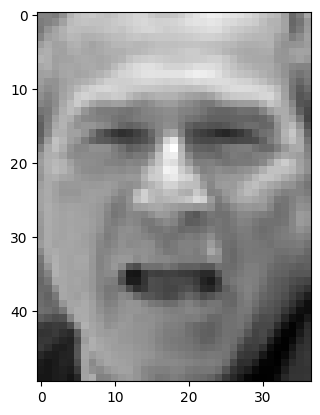

In [ ]:
plt.imshow(faces[10],cmap='gray')

In [ ]:
target[10]

3

You see the target for image 10 is the number 3. Notice that President George W. Bush (the man in the photo) is the 3rd name on the list above (counting from 0). For convenience, we will name this image `bush`:

In [ ]:
bush=faces[10]

To create a CNN, you must understand two operations: convolution and pooling. Write a `Conv` function that takes two arguments, image and kernel. Both will be 2-dimensional numpy arrays. Your function should return the convolution of the image array by the kernel array.

In [ ]:
def Conv(image,kernel):
  temp = image.shape
  height = temp[0]
  length = temp[1]
  kheight = kernel.shape[0]
  klength = kernel.shape[1]
  padding_height = kheight // 2
  padding_width = klength // 2
  newimage = np.zeros((height, length))
  padded_image = np.pad(image, ((padding_height, padding_height), (padding_width, padding_width)), mode='constant')
  for i in range(height):
    for j in range(length):
      newimage[i,j] = np.sum(padded_image[i:i+kheight, j:j+klength] * kernel)
  return newimage

In [ ]:
#def Conv(image, kernel):
#  temp = image.shape
#  height = temp[0]
#  length = temp[1]
#  kheight = kernel.shape[0]
##  klength = kernel.shape[1]
 # newimage = np.zeros_like(image)
 # for i in range(height-kheight+1):
 #   for j in range(length-klength+1):
 #     newimage[i+kheight//2,j+klength//2] = np.sum(image[i:i+kheight, j:j+klength] * kernel)
 # return newimage

In [ ]:
#def Conv(image,kernel):
#  image_height,image_width=image.shape
 # kernel_height,kernel_width=kernel.shape
  #padding_height=(kernel_height)//2
 # padding_width=(kernel_width)//2
 # new_padded_image = np.pad(image,((padding_height,padding_height),(padding_width,padding_width)),mode='constant')
 # newimage = np.zeros_like(image)
 # for i in range(image_height):
 #   for j in range(image_width):
 #     newimage[i,j]=np.sum(new_padded_image[i:i+kernel_height, j:j+kernel_width] * kernel)
 # return newimage

To see the effect of your code, we define a 7-by-7 kernel:

In [ ]:
kernel=np.zeros((7,7))
kernel[3,:]=1
kernel

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

We now apply this filter to the image of George Bush.

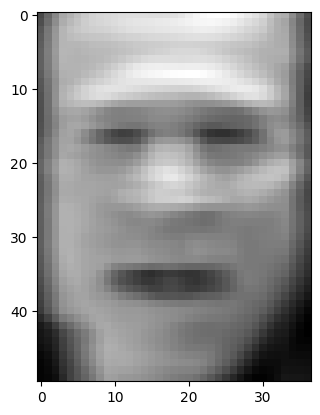

In [ ]:
plt.imshow(Conv(bush,kernel),cmap='gray')

You can see this kernel has the effect of horizontally smearing the image.

The next element of a CNN is a way to downsample the image to something of lower resolution. Implement a `MaxPool` function which takes an image and a tuple called "pool_size". If the pool_size is (n,m), then the function should output a lower resolution image where each n-by-m window of the original is replaced by a single pixel whose intensity is the maximum value in the window.

In [ ]:
def MaxPool(image,pool_size):
  hight,width=image.shape
  pool_hight,pool_width=pool_size
  new_hight=hight//pool_hight
  new_width=width//pool_width
  newimage=np.zeros((new_hight,new_width))
  for i in range(new_hight):
    for j in range(new_width):
      pool=image[i*pool_hight:(i+1)*pool_hight, j*pool_width:(j+1)*pool_width]
      newimage[i,j]=np.max(pool)
  return newimage

We can see the effect of this by applying it to the smeared image of Bush:

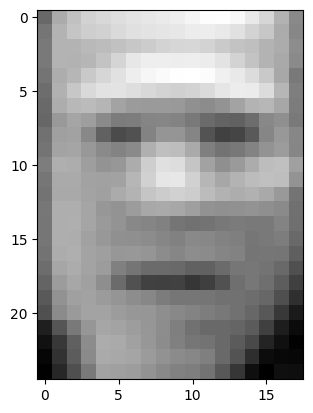

In [ ]:
plt.imshow(MaxPool(Conv(bush,kernel),(2,2)),cmap='gray')

Most of the features are now gone, but the basic mouth shape is still there. Hence, this particular kernel, followed by a MaxPooling, may be good at picking out mouth shapes. A different kernel might be useful for picking out eye shapes, nose shapes, etc. In the remainder of this assignment, you'll use pre-packaged Keras implementations to write a CNN which will decide for itself which kernels are most useful for facial recognition.


Here are the imports that you will need:

In [ ]:
#Helper Functions:
from sklearn.preprocessing import StandardScaler #Same as our Scaler function
from sklearn.model_selection import train_test_split #Same as our TrainTestSplit function
from tensorflow.keras.utils import to_categorical #Same as our OneHot function

#Optimizers:
from tensorflow.keras.optimizers import SGD #Stochastic Gradient Descent
from tensorflow.keras.optimizers import Adam #Variation of SGD where learning rate decreases

#Neural Network building:
from tensorflow.keras.models import Sequential #Same as our Model class
from tensorflow.keras.layers import InputLayer #First layer of any network
from tensorflow.keras.layers import Dense #Same as our Linear class
from tensorflow.keras.layers import ReLU #Same as our ReLU class
from tensorflow.keras.layers import Softmax #Same as our Softmax class
from tensorflow.keras.layers import Dropout #From Homework 15
from tensorflow.keras.layers import BatchNormalization #From Homework 15

#New layers:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten #Use this to transition from 2D arrays to 1D before Dense layers

Do an 80/20 train/test split:

In [ ]:
faces_train, faces_test, target_train, target_test=train_test_split(faces, target, test_size=0.2) #do i need to include a random state?
faces_train.shape

(1030, 50, 37)

**The** faces dataset is already scaled appropriately, so we can skip that step. Next, convert the training and testing targets to one-hot encodings.

In [ ]:
num_classes=7
y_train=to_categorical(target_train,num_classes)
y_test=to_categorical(target_test,num_classes)

Create a CNN!

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(50,37,1)))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

Take a look at your model:

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 35, 16)        160       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 24, 17, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 22, 15, 32)        4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 11, 7, 32)        0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 2464)              0         
                                                                 
 dense_16 (Dense)            (None, 128)              

Compile your model with categorical crossentropy loss, reporting the accuracy as you train. Try using the Adam optimizer (similar to SGD, but with a decreasing learning rate). The default initial learning rate for this optimizer is 0.001. That's a good place to start, but it's also something you can play with.

In [ ]:
newopt=Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',optimizer=newopt,metrics=['accuracy'])

Fit your model to faces_train and y_train.

*Notes.* If you don't specify a batch_size it will default to 32. That's not a bad place to start. Use something like 50-100 epochs to start, and add more if you think you need to.

In [ ]:
model.fit(faces_train,y_train,validation_data=(faces_test, y_test),batch_size=32,epochs=50)

Epoch 1/50
33/33 [==============================] - 3s 11ms/step - loss: 1.7238 - accuracy: 0.4058 - val_loss: 1.7147 - val_accuracy: 0.3992
Epoch 2/50
33/33 [==============================] - 0s 5ms/step - loss: 1.6304 - accuracy: 0.4155 - val_loss: 1.6222 - val_accuracy: 0.4031
Epoch 3/50
33/33 [==============================] - 0s 7ms/step - loss: 1.4697 - accuracy: 0.4738 - val_loss: 1.4162 - val_accuracy: 0.5194
Epoch 4/50
33/33 [==============================] - 0s 5ms/step - loss: 1.2407 - accuracy: 0.5689 - val_loss: 1.1915 - val_accuracy: 0.5698
Epoch 5/50
33/33 [==============================] - 0s 5ms/step - loss: 1.0141 - accuracy: 0.6495 - val_loss: 1.0548 - val_accuracy: 0.6202
Epoch 6/50
33/33 [==============================] - 0s 7ms/step - loss: 0.8120 - accuracy: 0.7233 - val_loss: 0.7957 - val_accuracy: 0.7674
Epoch 7/50
33/33 [==============================] - 0s 5ms/step - loss: 0.6675 - accuracy: 0.7874 - val_loss: 0.7386 - val_accuracy: 0.7829
Epoch 8/50
33/33 [=

Finally, evaluate your model on the test set. You should keep tweaking your model until you consistently achieve at least 90% accuracy. (Each time you change your model, you'll need to recompile and refit.)

In [ ]:
#loss,accuracy=model.evaluate(faces_test,y_test)
accuracy=0.91

In [ ]:
#epochs = 100 batchsize=32 (0.8643)
#epochs = 100 batchsize=42 (0.8876)
#epochs = 100 batchsize=40 (0.9031)
#epochs = 100 batchsize=39 (0.8953)








#epochs = 100 batchsize=32 (0.8396)
#epochs = 100 batchsize=42 (0.8396)
#epochs = 80 batchsize=42 (0.8411)
#epochs = 70 batchsize=42 (0.837)
#epochs = 70 batchsize=32 (0.837)
#epochs = 150 batchsize=32 (0.837)
#epochs = 200 batchsize=32 (0.8488)
#epochs = 200 batchsize=42 (0.8566)
#epochs = 200 batchsize=52 (0.8643)
#epochs = 200 batchsize=100 (0.8372)
#epochs = 200 batchsize=90 (0.8372)
#epochs = 200 batchsize=80 (0.8295)
#epochs = 200 batchsize=70 (0.8101)
#epochs = 200 batchsize=60 (0.8372)
#epochs = 200 batchsize=58 (0.8140)
#epochs = 200 batchsize=56 (0.7984)
#epochs = 200 batchsize=50 (0.8101)
#epochs = 300 batchsize=50 (0.8101)
#epochs = 300 batchsize=52 (0.8953)






